In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import h5py
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import sys

%matplotlib inline

import seaborn as sns

from scipy.stats import spearmanr, pearsonr, rankdata


path_to_configs = "../"
sys.path.append(path_to_configs)
from configs import * 
from models import * 

/home/nbbwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
path_to_average_IGs = "%s%s/AVERAGING/"%(path_to_configs + IG_save_path, SPECIFIC_FOLDER)

with h5py.File(path_to_configs + path_to_MDAD_data_folders + "ACT_MSBBRNA_ROSMAP.h5", 'r') as hf:
    gene_symbols = hf["gene_symbols"][:].astype(str)

path_to_save_scores = path_to_configs + path_to_gene_rankings + "MTL/"
avg_method = "weighted_avg_high_vs_low_path"

phenotypes = ['CERAD','BRAAK','PLAQUES','TANGLES','ABETA_IHC','TAU_IHC']
method = "MTL"

In [14]:
phen_dict = {"all": ['CERAD','BRAAK','PLAQUES','TANGLES','ABETA_IHC','TAU_IHC'], 
             "abeta": ['CERAD','PLAQUES','ABETA_IHC'],
            "tau": ['BRAAK','TANGLES','TAU_IHC']}

In [15]:
# ranks such that most positive value has rank 1
def weights_to_rankings(weights, direction="positive"):
    if direction=="positive":
        return  len(weights) - rankdata(weights)
    elif direction =="negative":
        return len(weights) - rankdata(-1*weights)
    else:
        return len(weights) - rankdata(abs(weights))

In [8]:
### COMBINE REPS
if method=="MTL":
    num_reps = 100
elif method == "MLP_baselines":
    num_reps = 10
    
    
num_cats_overlaps = num_reps

rep_gws = []
for i in range(num_reps):
    if i%10==0:
        print(i)
        
    GWs = []
    curpath  = "%s/%s/%i/outputs/"%(avg_method, method, i)
    ORDER = []
    for phenotype in phenotypes:
        ORDER.append(phenotype)
        path_to_IG_weights = path_to_average_IGs + "%s/%s/%i/outputs/%s.h5"%(avg_method, method, i, phenotype)

        with h5py.File(path_to_IG_weights, 'r') as hf:
            gene_weights = hf["gene_weights"][:]

        GWs.append(gene_weights)

    rep_gws.append(np.array(GWs))
rep_gws = np.array(rep_gws)

rep_ranks = {}
for direction in ["positive", "negative"]:
    rep_ranks[direction] = np.zeros([len(rep_gws), len(phenotypes), len(gene_symbols)])
    for i in range(num_reps):
        for p in range(len(phenotypes)):
            rep_ranks[direction][i,p,:] = weights_to_rankings(rep_gws[i,p,:], direction).astype(int)

positive
100
500
1000
2000
negative
100
500
1000
2000


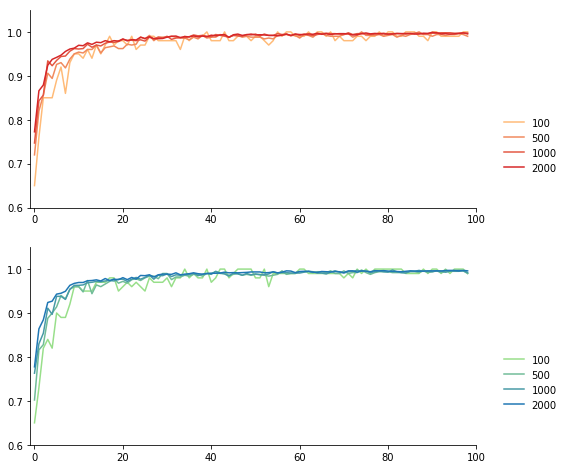

In [10]:
### PLOT THE CONSISTENCY OF RANKINGS AS THE NUMBER OF RUNS INCREASES

tops = [100,500,1000,2000]
agreement_fracs = {}
for direction in ["positive", "negative"]:
    print(direction)
    agreement_fracs[direction] = []
    for top_num in tops:
        print(top_num)
        agreement_frac = []
        currep = 1
        cur_top = []

        for currep in range(1,101):
            new_top = np.argsort(np.mean(np.mean(rep_ranks[direction],axis=1)[:currep,:],axis=0))[:top_num]
            agreement_frac.append(len(np.intersect1d(cur_top,new_top))/top_num)

            cur_top=new_top
        agreement_fracs[direction].append(agreement_frac)

cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]
warm_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cmaplist[3], cmaplist[6]])
cold_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cmaplist[5], cmaplist[0]])

colors = {"negative": [cold_cmap(x) for x in np.arange(4)/3],
         "positive": [warm_cmap(x) for x in np.arange(4)/3]}

f,ax=plt.subplots(2,1,figsize=(8,8))
for i,direction in enumerate(agreement_fracs.keys()):
    for j,a in enumerate(agreement_fracs[direction]):
        ax[i].plot(a[1:], c=colors[direction][j])
        ax[i].set_ylim(.6,1.05)

        ax[i].legend(tops, bbox_to_anchor=(1.2, 0.5), frameon=False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].set_xlim(-1,100)

In [11]:
scores = rep_ranks["negative"]/(len(gene_symbols)-1)
consensus_scores = np.mean(scores,axis=0)

In [12]:
### SAVE rnk FILES (used for gseapy)
### SAVE FINAL RANKINGS FOR EACH PHENOTYPE AND COMBINED ACROSS GROUPS


if not os.path.isdir(path_to_save_scores):
    os.makedirs(path_to_save_scores)


for i,p in enumerate(phenotypes):
    to_save_c_scores = consensus_scores[i]
    
    scores_df = pd.DataFrame(np.vstack([gene_symbols,to_save_c_scores]).T, columns=["gene", "score"])
    scores_df["score"] = scores_df["score"].astype(float)
    scores_df = scores_df.sort_values("score", ascending=False)
    scores_df = scores_df.reset_index(drop=True)
    scores_df.to_csv("%s%s.rnk"%(path_to_save_scores,p), sep="\t", header=False, index=False)
for p_group in ["all", "abeta", "tau"]:
    p_idx = np.where(np.in1d(phenotypes, phen_dict[p_group]))[0]
    to_save_c_scores = np.mean(consensus_scores[p_idx],axis=0)
    scores_df = pd.DataFrame(np.vstack([gene_symbols,to_save_c_scores]).T, columns=["gene", "score"])
    scores_df["score"] = scores_df["score"].astype(float)
    scores_df = scores_df.sort_values("score", ascending=False)
    scores_df = scores_df.reset_index(drop=True)
    scores_df.to_csv("%s%s-related.rnk"%(path_to_save_scores,p_group), sep="\t", header=False, index=False)

In [13]:
current_ranking =pd.read_csv("%s%s-related.rnk"%(path_to_save_scores,"all"), sep="\t", names=["gene", "all-related_score"])
for group in [x+"-related" for x in ["abeta", "tau"]] + phenotypes:
    new_df = pd.read_csv("%s%s.rnk"%(path_to_save_scores,group), names=["gene", "%s_score"%group], sep="\t")
    current_ranking = current_ranking.merge(new_df, on="gene", how="left")

In [14]:
current_ranking.to_csv(path_to_save_scores + "ALL_CONSENSUS_SCORES.csv")
print("Saved rankings to %s"%path_to_save_scores)

Saved rankings to gene_rankings/MTL/


In [16]:
current_ranking

,gene,all-related_score,abeta-related_score,tau-related_score,CERAD_score,BRAAK_score,PLAQUES_score,TANGLES_score,ABETA_IHC_score,TAU_IHC_score
0,LTF,0.995079,0.993589,0.996570,0.981137,0.998577,0.999790,0.997333,0.999840,0.993800
1,GFAP,0.994337,0.991491,0.997183,0.986910,0.996999,0.998131,0.998185,0.989434,0.996364
2,PLCE1,0.991850,0.987225,0.996475,0.982607,0.995240,0.988550,0.996248,0.990520,0.997938
3,FPR3,0.989940,0.980321,0.999558,0.977889,0.999466,0.972891,0.999630,0.990184,0.999578
4,C4B,0.989068,0.991008,0.987128,0.983962,0.993636,0.997381,0.991894,0.991683,0.975855
5,ZNF98,0.983882,0.975820,0.991944,0.932888,0.979997,0.998801,0.996981,0.995770,0.998855
6,NPNT,0.983798,0.971509,0.996087,0.948230,0.994291,0.982867,0.997115,0.983429,0.996853
7,SLC28A2,0.981269,0.977695,0.984842,0.957303,0.977673,0.990496,0.980385,0.985286,0.996469
8,EFHB,0.978510,0.959493,0.997527,0.951840,0.999060,0.965903,0.998450,0.960735,0.995071
9,KNSTRN,0.978430,0.974707,0.982152,0.964621,0.982350,0.988344,0.983165,0.971157,0.980941
